In [5]:
from algorithm.ppo import Learner
from configs.args_parser import Parameters
from configs import Factor_dictionary
from algorithm.analysis import MO_Analysis
from algorithm.utils import MO_Stats
import mo_gymnasium as mo_gym 
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from algorithm.utils import make_styled_env
from io import BytesIO
import os
import io
import gymnasium as gym
from configs import Factor_dictionary
env_id = 'mo-halfcheetah-v4'


In [6]:
env = gym.make(env_id)

In [9]:
type(env.action_space) == gym.spaces.Box

True

## MORL Envs

In [4]:
factors = Factor_dictionary[env_id]
Sampler = Factor_Sampler(factors)
weights,styles = Sampler.generate_reward_factors(10)
env_list = []
for i,weight in enumerate(weights):
    env_list.append(make_styled_env(env_id,0,weight))
envs = gym.vector.SyncVectorEnv(env_list)
envs = gym.wrappers.RecordEpisodeStatistics(envs)

obs,_ = envs.reset()
for _ in range(1000):
    action = envs.action_space.sample()
    next_obs, reward, done,truncted, info = envs.step(action)

    if "episode" in info.keys():
        for i,terminate in enumerate(info['_episode']):
            if terminate:
                print(info)

/home/jijingtian/anaconda3/envs/morl/lib/python3.7/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


{'vector_reward': array([array([ 0.  ,  0.  , -0.12]), array([ 0.  ,  0.  , -0.02]),
       array([ 0.  ,  0.  , -0.02]), array([ 0.  ,  0.  , -0.02]), None,
       array([ 0.  ,  0.  , -0.12]), array([ 0.  ,  0.  , -0.02]),
       array([ 0.  ,  0.  , -0.02]), array([ 0.  ,  0.  , -0.22]),
       array([ 0.  ,  0.  , -0.12])], dtype=object), '_vector_reward': array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True]), 'final_observation': array([None, None, None, None,
       array([ 0.01989863,  0.13835149,  0.03      , -0.81915206, -0.57357645,
               0.        ,  0.        ], dtype=float32)                       ,
       None, None, None, None, None], dtype=object), '_final_observation': array([False, False, False, False,  True, False, False, False, False,
       False]), 'final_info': array([None, None, None, None,
       {'vector_reward': array([ 0.  ,  0.  , -0.12])}, None, None, None,
       None, None], dtype=object), '_final_info': array([Fal

In [9]:
data_dict = np.load("logs/deep-sea-treasure-v0_SamplerTest/sampler_debug.npz")

In [10]:
data_dict.keys()

KeysView(<numpy.lib.npyio.NpzFile object at 0x7fb93d7b4048>)

In [12]:
data_dict['sample_tis']

KeyError: 'sample_tis is not a file in the archive'

# Debugs

In [2]:
data = np.load("logs/deep-sea-treasure-v0_code_test/5.npz")

In [4]:
data['to_sample']

array([0, 1, 2, 3, 4])

In [19]:
to_count = []
for i in range(400,485,5):
    data = np.load(f"logs/deep-sea-treasure-v0_code_test/{i}.npz")
    to_count += data['to_sample'].tolist()

In [20]:
counts = np.bincount(to_count)


(array([ 73.,  90.,  78.,  98.,  96., 116., 101., 136., 108., 106.]),
 array([  0.,  44.,  88., 132., 176., 220., 264., 308., 352., 396., 440.]),
 <BarContainer object of 10 artists>)

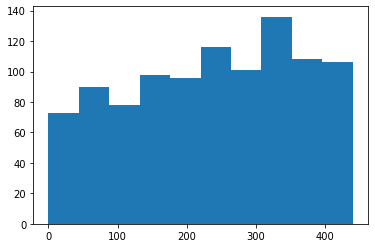

In [21]:
import matplotlib.pyplot as plt

plt.hist(to_count)